In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from medmnist import PathMNIST

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("using cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("using mps")
else:
    print("none")

using cuda


In [5]:
# Download and load PathMNIST dataset
data_flag = 'pathmnist'
download = True

# transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Load datasets with transforms
train_dataset = PathMNIST(split='train', transform=train_transform, download=True)
val_dataset = PathMNIST(split='val', transform=test_transform, download=True)
test_dataset = PathMNIST(split='test', transform=test_transform, download=True)

# data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(np.unique(train_dataset.labels))}")

100%|██████████| 205615438/205615438 [00:16<00:00, 12684073.40it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Training samples: 89996
Validation samples: 10004
Test samples: 7180
Number of classes: 9


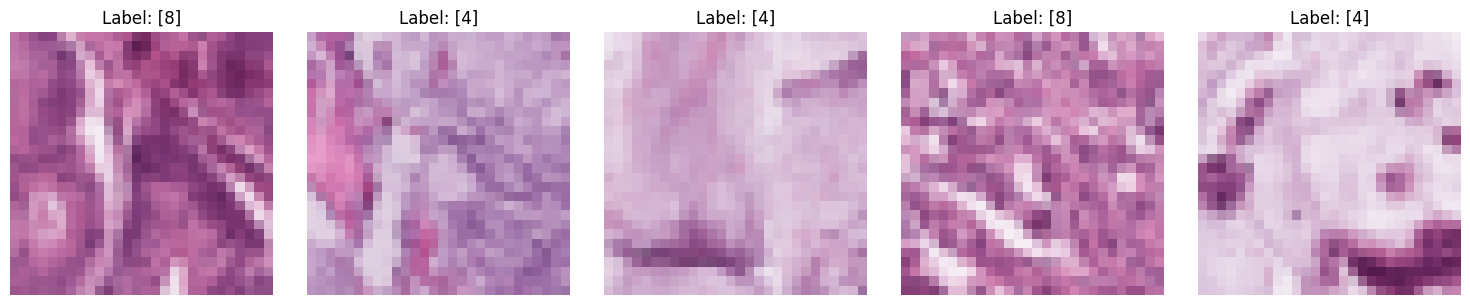

In [6]:
save_dir = 'example_images'
os.makedirs(save_dir, exist_ok=True)

test_dataset_original = PathMNIST(split='test', transform=None, download=True)
dataset_size = len(test_dataset_original)
num_samples = 10
random_indices = np.random.choice(dataset_size, size=num_samples, replace=False)

# Visualize random samples
figure = plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_indices):
    image, label = test_dataset_original[idx]
    image.save(os.path.join(save_dir, f'sample_{idx}_label_{label}.png'))
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
img shape: (28, 28, 3)
img shape: (28, 28, 3)
img shape: (28, 28, 3)
img shape: (28, 28, 3)


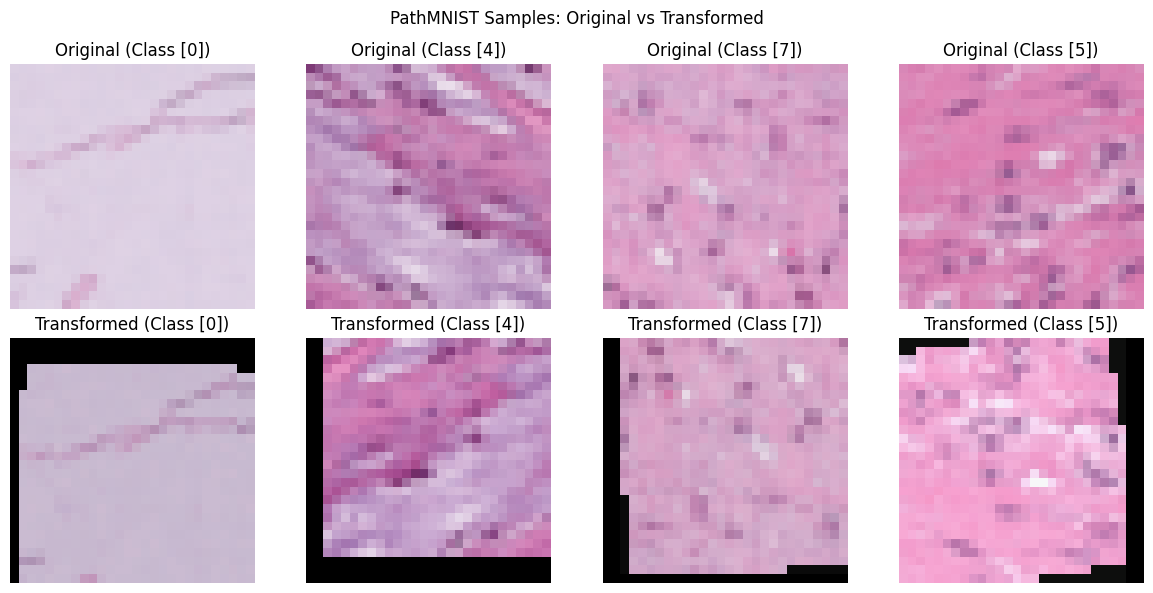

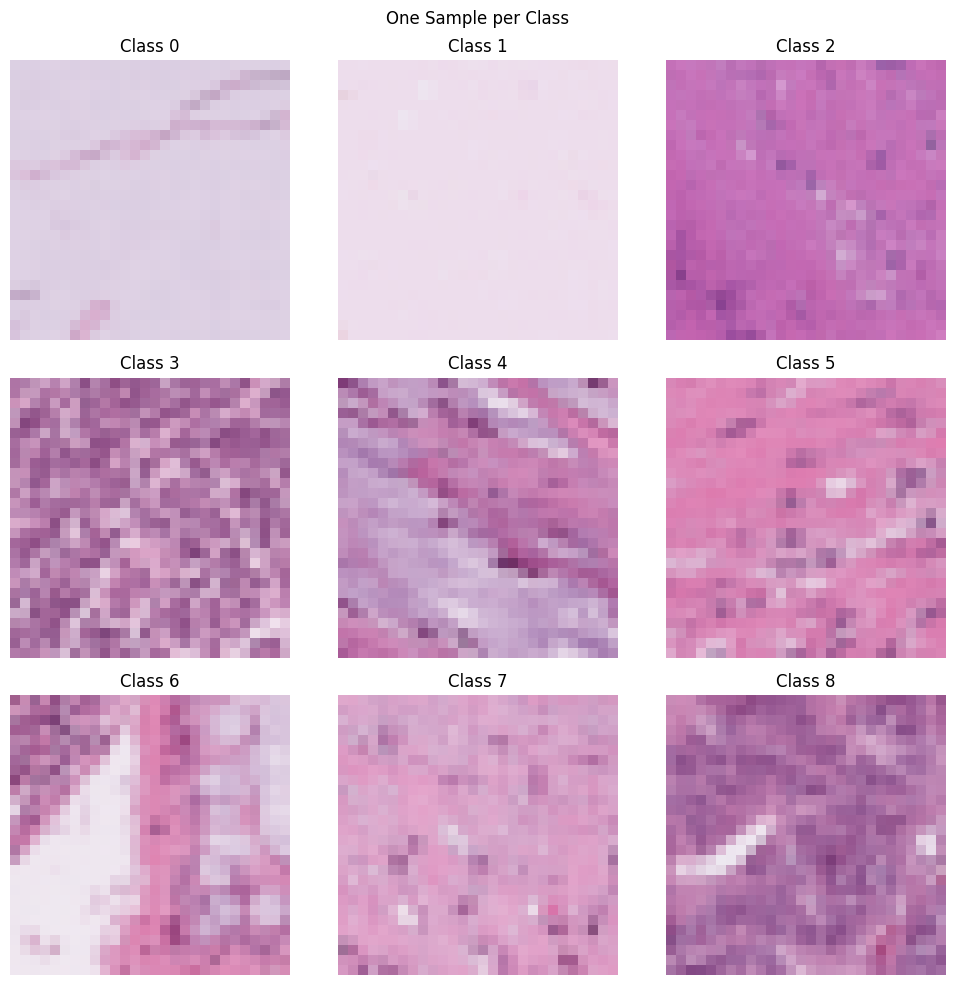

In [7]:
# Load untransformed dataset for visualization and comparison
dataset_original = PathMNIST(split='train', download=True)

# Original vs transformed
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
plt.suptitle('PathMNIST Samples: Original vs Transformed')

for i in range(4):
    img_orig, label_orig = dataset_original[i]
    img_trans, label_trans = train_dataset[i]
    
    # Plot original
    axes[0,i].imshow(img_orig)
    axes[0,i].set_title(f'Original (Class {label_orig})')
    axes[0,i].axis('off')
    
    # Plot transformed, unnormalize the transformed image
    img_trans = img_trans.numpy().transpose((1, 2, 0))
    img_trans = img_trans * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_trans = np.clip(img_trans, 0, 1)
    # print("img shape:", np.array(img_trans).shape)

    
    axes[1,i].imshow(img_trans)
    axes[1,i].set_title(f'Transformed (Class {label_trans})')
    axes[1,i].axis('off')

plt.tight_layout()
plt.show()

# One sample from each class
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
plt.suptitle('One Sample per Class')

for class_idx in range(9):
    for idx in range(len(dataset_original)):
        img, label = dataset_original[idx]
        if label == class_idx:
            ax = axes[class_idx//3, class_idx%3]
            ax.imshow(img)
            ax.set_title(f'Class {class_idx}')
            ax.axis('off')
            break

plt.tight_layout()
plt.show()

In [8]:
class PathMNISTCNN(nn.Module):
    def __init__(self):
        super(PathMNISTCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 28x28x3 -> 28x28x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2)  # 28x28x32 -> 14x14x32
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 14x14x32 -> 14x14x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 14x14x64 -> 7x7x64
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 7x7x64 -> 7x7x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 7x7x128 -> 3x3x128
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),  # 3x3x128 -> 1152
            nn.Linear(3 * 3 * 128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 9)  # 9 classes output
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

# model instance
model = PathMNISTCNN()
print(model)

PathMNISTCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): 

In [9]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.squeeze()).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [10]:
def train_epoch(model, train_loader, criterion, optimizer, device, print_interval=100):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the param gradients
        optimizer.zero_grad()
        
        # Fwd prop
        outputs = model(inputs)

        # Backprop
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        # Update
        optimizer.step()
        
        # Stats
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels.squeeze()).sum().item()
        
        # Print every print_interval mini-batches
        if (batch_idx + 1) % print_interval == 0:
            current_loss = running_loss / (batch_idx + 1)
            current_acc = 100. * correct / total
            print(f'  Batch [{batch_idx + 1}/{len(train_loader)}] | Loss: {current_loss:.4f} | Acc: {current_acc:.2f}%')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [11]:
# Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
model = model.to(device)
num_epochs = 4

print(f"Training on {device}")
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    
    # train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, print_interval=100)
    
    # validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    
    # Print epoch summary
    print('Epoch Summary:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)

print("Finished training")

Training on cuda

Epoch [1/4]
  Batch [100/2813] | Loss: 1.8696 | Acc: 29.91%
  Batch [200/2813] | Loss: 1.7079 | Acc: 35.77%
  Batch [300/2813] | Loss: 1.6222 | Acc: 39.11%
  Batch [400/2813] | Loss: 1.5481 | Acc: 41.63%
  Batch [500/2813] | Loss: 1.4926 | Acc: 43.71%
  Batch [600/2813] | Loss: 1.4489 | Acc: 45.34%
  Batch [700/2813] | Loss: 1.4115 | Acc: 46.78%
  Batch [800/2813] | Loss: 1.3824 | Acc: 48.11%
  Batch [900/2813] | Loss: 1.3538 | Acc: 49.27%
  Batch [1000/2813] | Loss: 1.3282 | Acc: 50.31%
  Batch [1100/2813] | Loss: 1.3053 | Acc: 51.20%
  Batch [1200/2813] | Loss: 1.2915 | Acc: 51.76%
  Batch [1300/2813] | Loss: 1.2703 | Acc: 52.56%
  Batch [1400/2813] | Loss: 1.2519 | Acc: 53.35%
  Batch [1500/2813] | Loss: 1.2338 | Acc: 54.06%
  Batch [1600/2813] | Loss: 1.2170 | Acc: 54.67%
  Batch [1700/2813] | Loss: 1.2032 | Acc: 55.22%
  Batch [1800/2813] | Loss: 1.1889 | Acc: 55.81%
  Batch [1900/2813] | Loss: 1.1744 | Acc: 56.43%
  Batch [2000/2813] | Loss: 1.1613 | Acc: 56.98%

In [12]:
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    # For storing all predictions and true labels
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.squeeze()).sum().item()
            
            # Store predictions and labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.squeeze().cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.2f}%')
    return test_loss, test_acc, all_predictions, all_labels

# use best model
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)
# run evaluation
test_loss, test_acc, predictions, true_labels = test(model, test_loader, criterion, device)

<ipython-input-12-f87180ea75f3>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.3914
Test Accuracy: 86.25%


In [18]:
checkpoint = torch.load('best_model.pth')
print(type(checkpoint)) 

<class 'collections.OrderedDict'>
